### - Fine-tune ResNet, ConvNext and EfficientNet for your augmented dataset for human/robot classification and compare them.
### - Compare the following on a model of your choice: Fine-Tuned model, model as fixed feature extractor, and model with a Combined Approach

# <center>____________________________ Data ____________________________</center>

In [27]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch
import torch.nn as nn
from tqdm import tqdm;

In [43]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

As noralization is part of data transformation, we need the means and stds for the three chanels. I'll begin by obtaining these values on the 'training + validation' data as a whole, since no information from test data should leak to the model at any point (totally unseen data). Later on, when I'm evaluating the model on the test set, I will have to use the means and stds obtained over 'training + validation' to perform transforms. Because again, the model should "supposedly" have no information whatsoever of what it will be up against (test data).

In [4]:
# Resize and ToTensor only (no normalization yet)
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("dataset/train", transform=temp_transform)
val_set = datasets.ImageFolder("dataset/val", transform=temp_transform)

train_and_val = ConcatDataset([train_set, val_set])

loader = DataLoader(train_and_val, batch_size=32, shuffle=False)

In [5]:
# Get mean and std for the R, G, and B channels
def get_mean_std(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.

    for data, _ in tqdm(loader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # flatten H and W
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [6]:
mean, std = get_mean_std(loader)
print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

100%|██████████| 4/4 [00:07<00:00,  1.83s/it]

Calculated Mean: tensor([0.4704, 0.4458, 0.4169])
Calculated Std: tensor([0.2250, 0.2159, 0.2180])


Now the pre-trainning transformers

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

In [11]:
train_dataset = datasets.ImageFolder('dataset/train', transform=train_transform)
val_dataset   = datasets.ImageFolder('dataset/val', transform=val_transform)
test_dataset  = datasets.ImageFolder('dataset/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

Now that the data is ready, we can proceed to the Models

# <center>____________________________ Models ____________________________</center>

In [14]:
torch.cuda.is_available()

True

In [35]:
device = torch.device("cuda")

In [56]:
from torch.utils.tensorboard import SummaryWriter

In [46]:
# from torchvision.transforms import v2
# cutmix = v2.CutMix(num_classes=NUM_CLASSES)

In [47]:
# Utility functions defined below are adapted from lecture material by Angel Villar Coralles.

def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        # images, labels = cutmix(images labels)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, tboard=None, start_epoch=0):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    assert tboard is not None, f"Tensorboard must be provided!"
    
    for epoch in tqdm(range(num_epochs)):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        tboard.add_scalar(f'Accuracy/Valid', accuracy, global_step=epoch+start_epoch)
        tboard.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        tboard.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [48]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

# Using common default random seed 13
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

### Finetuning ResNet18

In [50]:
from torchvision.models import resnet18
set_random_seed()
model = resnet18(pretrained=True)

In [51]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [52]:
# replacing classification head with a single linear layer that outputs 2 logits
# It is more streamlined to get the head number of inputs as below
num_logits = model.fc.in_features
# model.fc = nn.Linear(num_logits, 2)
model.fc = nn.Sequential(
    nn.Linear(num_logits, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2)
)

model = model.to(device)

In [53]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 3 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [57]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Task1_Logs", "ResNet18_Tuned")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [59]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=30, tboard=writer
    )

  3%|▎         | 1/30 [00:07<03:42,  7.67s/it]

Epoch 1/30
    Train loss: 0.44064
    Valid loss: 0.65362
    Accuracy: 71.875%




 20%|██        | 6/30 [00:40<02:38,  6.59s/it]

Epoch 6/30
    Train loss: 0.00764
    Valid loss: 0.0045
    Accuracy: 100.0%




 37%|███▋      | 11/30 [01:12<02:04,  6.54s/it]

Epoch 11/30
    Train loss: 0.0034
    Valid loss: 0.00597
    Accuracy: 100.0%




 53%|█████▎    | 16/30 [01:45<01:31,  6.52s/it]

Epoch 16/30
    Train loss: 0.00969
    Valid loss: 0.00563
    Accuracy: 100.0%




 70%|███████   | 21/30 [02:18<00:58,  6.54s/it]

Epoch 21/30
    Train loss: 0.00339
    Valid loss: 0.0054
    Accuracy: 100.0%




 87%|████████▋ | 26/30 [02:50<00:26,  6.52s/it]

Epoch 26/30
    Train loss: 0.01292
    Valid loss: 0.00519
    Accuracy: 100.0%




100%|██████████| 30/30 [03:16<00:00,  6.56s/it]

Epoch 30/30
    Train loss: 0.00744
    Valid loss: 0.00491
    Accuracy: 100.0%


Training completed


<ipython-input-60-e0510c29302a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


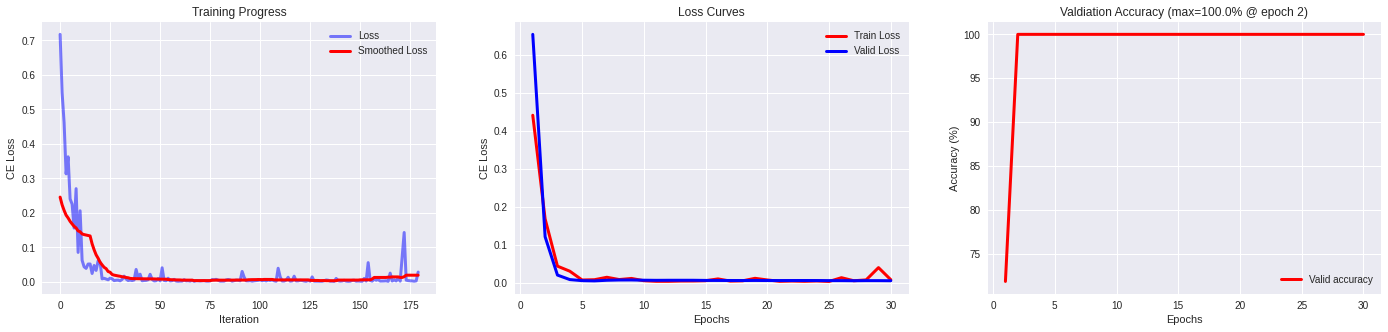

In [60]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()